![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
import re
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


# DATA

In [2]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
df_train.info()
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [3]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
sample               10000 non-null int64
Rating               10000 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 859.5+ KB


In [4]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [5]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [6]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
43230,id_4438,Berlin,"['Steakhouse', 'Argentinean']",4440.0,$$ - $$$,165.0,"[['Perfectly fine steaks, exactly as I expect....",/Restaurant_Review-g187323-d3536742-Reviews-Ro...,d3536742,1,3.5
40662,id_11,Hamburg,"['Seafood', 'Mediterranean', 'European', 'Glut...",12.0,$,467.0,"[['Friendly fish 👌🏻', 'Most delicious fresh fi...",/Restaurant_Review-g187331-d5501102-Reviews-Ka...,d5501102,1,4.5
33013,id_9004,Paris,NaN,9006.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187147-d5798918-Reviews-La...,d5798918,1,4.5
9407,id_9407,Vienna,"['Chinese', 'Asian', 'Indonesian']",1087.0,$$ - $$$,16.0,"[['Really good food', 'Regular guests'], ['02/...",/Restaurant_Review-g190454-d2179429-Reviews-QU...,d2179429,0,0.0
19523,id_2032,Lisbon,NaN,2035.0,NaN,NaN,"[[], []]",/Restaurant_Review-g189158-d5603650-Reviews-Bo...,d5603650,1,5.0


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак.

In [7]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)
data['Number_of_Reviews_isNAN']


0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [8]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

## Обработка City

In [9]:
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
27933,id_10397,['French'],10399.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187147-d6153951-Reviews-Ap...,d6153951,1,4.5,...,0,0,1,0,0,0,0,0,0,0
7826,id_7826,NaN,2655.0,NaN,9.0,"[[], []]",/Restaurant_Review-g1166685-d12112519-Reviews-...,d12112519,0,0.0,...,0,0,0,0,0,0,0,0,0,0
39845,id_190,"['European', 'Central European']",191.0,$$ - $$$,37.0,"[['Amazing!!!!', 'Business trip in Bratislava'...",/Restaurant_Review-g274924-d7811549-Reviews-Fa...,d7811549,1,4.0,...,0,0,0,0,0,0,0,0,0,0
47199,id_2253,"['European', 'Central European', 'Hungarian']",2254.0,$$ - $$$,113.0,[['Good location opposite Synagogue - food ok'...,/Restaurant_Review-g274887-d1804310-Reviews-Wa...,d1804310,1,3.0,...,0,0,0,0,0,0,0,0,0,0
9999,id_9999,NaN,6791.0,NaN,14.0,"[['Ethiopian Dining in Pleasant Space'], ['07/...",/Restaurant_Review-g187147-d10342814-Reviews-L...,d10342814,0,0.0,...,0,0,1,0,0,0,0,0,0,0


## Обработка Price Range

In [10]:
data['Price Range'].isna()

0        False
1        False
2        False
3        False
4        False
         ...  
49995    False
49996    False
49997     True
49998    False
49999    False
Name: Price Range, Length: 50000, dtype: bool

Представим данные в этом столбце как категорияальные, так как это относится к ценовой категории ресторана.

In [11]:
data = pd.get_dummies(data, columns=['Price Range'], dummy_na=True)

In [12]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,...,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$,Price Range_nan
21670,id_1511,['Sushi'],1515.0,5.0,"[['Good takeaway food', 'Decent takeaway'], ['...",/Restaurant_Review-g186605-d10465840-Reviews-M...,d10465840,1,4.0,0,...,0,0,0,0,0,0,0,1,0,0
43896,id_12805,['Cafe'],12815.0,10.0,"[['Are they still open?', 'Staff very rude!!!!...",/Restaurant_Review-g186338-d7220771-Reviews-Ba...,d7220771,1,3.5,0,...,0,0,0,0,0,0,1,0,0,0
38740,id_250,"['Italian', 'Mediterranean', 'European', 'Vege...",251.0,180.0,"[['A wonderful culinary experience', 'Deliciou...",/Restaurant_Review-g187849-d2185793-Reviews-Ri...,d2185793,1,4.5,0,...,0,0,0,0,0,0,0,1,0,0
42544,id_1620,"['French', 'International']",1621.0,8.0,"[['Very nice atmosphere', 'Nice food, good ser...",/Restaurant_Review-g188644-d1940683-Reviews-Be...,d1940683,1,4.5,0,...,0,0,0,0,0,0,0,0,0,1
29962,id_2686,NaN,2674.0,0.0,"[['Ethiopian, Erythrean and...'], ['12/02/2008']]",/Restaurant_Review-g188644-d1216006-Reviews-Sa...,d1216006,1,3.0,1,...,0,0,0,0,0,0,0,0,0,1


> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

## Обработка Cuisine Style

Посмотрим на весь столбец

In [13]:
data['Cuisine Style']

0                                           ['Bar', 'Pub']
1        ['European', 'Scandinavian', 'Gluten Free Opti...
2                                  ['Vegetarian Friendly']
3        ['Italian', 'Mediterranean', 'European', 'Vege...
4        ['Italian', 'Mediterranean', 'European', 'Seaf...
                               ...                        
49995    ['Italian', 'Vegetarian Friendly', 'Vegan Opti...
49996    ['French', 'American', 'Bar', 'European', 'Veg...
49997                                ['Japanese', 'Sushi']
49998    ['Polish', 'European', 'Eastern European', 'Ce...
49999                                          ['Spanish']
Name: Cuisine Style, Length: 50000, dtype: object

Посчитаем количество кухонь для каждого ресторана. А также сформируем множество всех кухонь в отдельный сет. Еще заполним пустые значения значением 'European', т.к. это значение наиболее точно будет отвечать нашим кухням, т.к. их большинство и все города европейские.

In [14]:
data['Cuisine Style'] = data['Cuisine Style'].fillna('European') 
cuisines_set = set()
def patt_cuisine_style(cuisine):
    if cuisine == 0:
        return 0
    else:
        pattern_cuisine = re.compile('[ a-zA-Z]+')
        cuisines = pattern_cuisine.findall(cuisine)
        cuisines = [item for item in cuisines if len(item) > 1]
        for cuisine in cuisines:
            cuisines_set.add(cuisine)
        return len(cuisines)
data['Cuisine Style count'] = data['Cuisine Style'].fillna(0).apply(patt_cuisine_style)    

In [15]:
cuisines_set

{' Creole',
 'Afghani',
 'African',
 'Albanian',
 'American',
 'Arabic',
 'Argentinean',
 'Armenian',
 'Asian',
 'Australian',
 'Austrian',
 'Azerbaijani',
 'Balti',
 'Bangladeshi',
 'Bar',
 'Barbecue',
 'Belgian',
 'Brazilian',
 'Brew Pub',
 'British',
 'Burmese',
 'Cafe',
 'Cajun ',
 'Cambodian',
 'Canadian',
 'Caribbean',
 'Caucasian',
 'Central American',
 'Central Asian',
 'Central European',
 'Chilean',
 'Chinese',
 'Colombian',
 'Contemporary',
 'Croatian',
 'Cuban',
 'Czech',
 'Danish',
 'Delicatessen',
 'Diner',
 'Dutch',
 'Eastern European',
 'Ecuadorean',
 'Egyptian',
 'Ethiopian',
 'European',
 'Fast Food',
 'Filipino',
 'French',
 'Fujian',
 'Fusion',
 'Gastropub',
 'Georgian',
 'German',
 'Gluten Free Options',
 'Greek',
 'Grill',
 'Halal',
 'Hawaiian',
 'Healthy',
 'Hungarian',
 'Indian',
 'Indonesian',
 'International',
 'Irish',
 'Israeli',
 'Italian',
 'Jamaican',
 'Japanese',
 'Korean',
 'Kosher',
 'Latin',
 'Latvian',
 'Lebanese',
 'Malaysian',
 'Mediterranean',
 'M

Добавим столбцы, в зависимости от наличия кухни в ресторане.

In [16]:
def add_cuisines(cuisine_style):
    if cuisine in cuisine_style:
        return 1
    return 0

for cuisine in cuisines_set:
    data[cuisine] = data['Cuisine Style'].apply(add_cuisines)

In [17]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,...,Japanese,Australian,Gluten Free Options,Tunisian,South American,Brew Pub,Mexican,Southwestern,African,Vietnamese
34631,id_2718,"['Italian', 'Pizza', 'Mediterranean']",2719.0,37.0,"[['Pretentious, overpriced pizza place', 'Awef...",/Restaurant_Review-g188644-d778807-Reviews-Vin...,d778807,1,3.0,0,...,0,0,0,0,0,0,0,0,0,0
19858,id_14114,"['Bar', 'Pizza', 'Pub']",14124.0,14.0,"[['Disappointing', 'Disappointing again !'], [...",/Restaurant_Review-g186338-d6384835-Reviews-Th...,d6384835,1,3.5,0,...,0,0,0,0,0,0,0,0,0,0
15080,id_121,"['Mediterranean', 'Greek', 'Vegetarian Friendl...",122.0,131.0,"[['This place is a gem!', 'Like Eating with Fa...",/Restaurant_Review-g189400-d5312490-Reviews-Ta...,d5312490,1,5.0,0,...,0,0,0,0,0,0,0,0,0,0
48236,id_2132,['Spanish'],2134.0,81.0,"[['The best bacalao of Madrid', 'First time an...",/Restaurant_Review-g187514-d1122246-Reviews-La...,d1122246,1,4.0,0,...,0,0,0,0,0,0,0,0,0,0
36486,id_1009,"['Mediterranean', 'Grill', 'International']",1010.0,9.0,"[['Great views at night', 'Great View with Gre...",/Restaurant_Review-g274887-d12564516-Reviews-I...,d12564516,1,4.0,0,...,0,0,0,0,0,0,0,0,0,0


# Обработка Reviews

Столбец Reviews содержит 2 отзыва и даты их написания на сайте. Вытянем из этого столбца информацию о количестве отзывов и количестве дат, записав эти данные в новые столбцы

In [18]:
def patt_reviews_text(review):
    pattern_review = re.compile('[ a-zA-Z]+')
    reviews = pattern_review.findall(str(review))
    reviews = [item for item in reviews if len(item) > 1]
    return reviews

def patt_reviews_dates(review):
    pattern_dates = re.compile('\d\d/\d\d/\d\d\d\d')
    dates = pattern_dates.findall(str(review))
    return dates

In [19]:
data['Reviews']

0                                                 [[], []]
1        [['Very good reviews!', 'Fine dining in Hakani...
2        [['Better than the Links', 'Ivy Black'], ['12/...
3        [['Most exquisite', 'Delicious and authentic']...
4        [['Always the best in bratislava', 'Very good ...
                               ...                        
49995    [['The real Italian experience!', 'Wonderful f...
49996    [['Parisian atmosphere', 'Bit pricey but inter...
49997    [['Good by swedish standards', 'A hidden jewel...
49998    [['Underground restaurant', 'Oldest Restaurant...
49999    [['Average', 'Nice an informal'], ['01/31/2016...
Name: Reviews, Length: 50000, dtype: object

In [20]:
data['Review_text'] = data['Reviews'].apply(patt_reviews_text)
data['Review_dates'] = data['Reviews'].apply(patt_reviews_dates)

Посчитаем еще разницу в днях, между первой и второй датой отзыва. И добавим новый столбец с этими данными.

In [21]:
def calc_difference(rev_dates):
    if len(rev_dates) > 1:
        return np.abs((pd.to_datetime(rev_dates[0]) - pd.to_datetime(rev_dates[1])).days)
    else:
        return 0
data['Difference date reviews (days)'] = np.abs(data['Review_dates'].apply(calc_difference))

И посчитаем количество дат и текстовых отзывов. И добавим новые столбцы с этими данными.

In [22]:
data['Count text'] = data['Review_text'].apply(lambda x: len(x))
data['Count dates'] = data['Review_dates'].apply(lambda x: len(x))

Удалим столбцы с данными 'Review_text' и 'Review_dates'

In [23]:
data = data.drop(['Review_text','Review_dates'], axis=1)

# Обработка ID_TA

Добавим еще один признак, обозначающий количество символов в идентификаторе ID_TA

In [24]:
data['ID_TA_len'] = data['ID_TA'].apply(lambda x: len(x))

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

In [25]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,...,South American,Brew Pub,Mexican,Southwestern,African,Vietnamese,Difference date reviews (days),Count text,Count dates,ID_TA_len
19955,id_3213,"['Bar', 'Czech', 'Central European', 'European...",3220.0,62.0,"[['Interesting', 'Amazing range of food'], ['0...",/Restaurant_Review-g274707-d7138824-Reviews-Ho...,d7138824,1,3.5,0,...,0,0,0,0,0,0,4,2,2,8
45986,id_2296,"['Bar', 'Cafe', 'Pub']",2300.0,5.0,"[[], []]",/Restaurant_Review-g187331-d8370651-Reviews-Ba...,d8370651,1,3.5,0,...,0,0,0,0,0,0,0,0,0,8
5670,id_5670,"['Chinese', 'Asian', 'Vietnamese', 'Fusion', '...",803.0,369.0,"[[""A vegetarian's staple go-to restaurant"", 'G...",/Restaurant_Review-g187147-d786928-Reviews-Tie...,d786928,0,0.0,0,...,0,0,0,0,0,1,9,4,2,7
32908,id_9330,"['European', 'French', 'International', 'Veget...",9332.0,107.0,"[['Top floor of Galeries Lafayette', 'First co...",/Restaurant_Review-g187147-d5259748-Reviews-La...,d5259748,1,3.5,0,...,0,0,0,0,0,0,30,2,2,8
42464,id_443,"['Asian', 'Vegetarian Friendly']",444.0,38.0,"[['«\xa0Difficult to find, but it is worth try...",/Restaurant_Review-g274856-d9779765-Reviews-Mo...,d9779765,1,4.0,0,...,0,0,0,0,0,0,15,4,2,8


# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

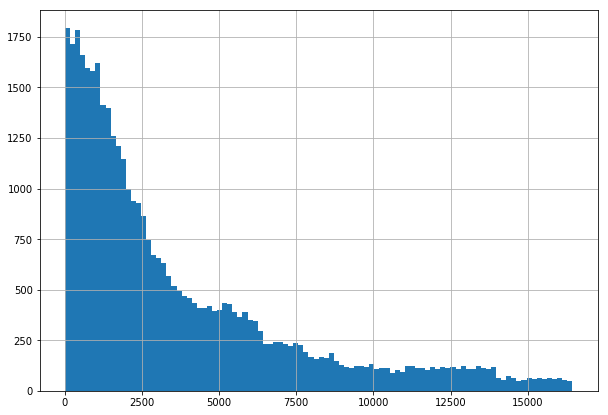

In [26]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

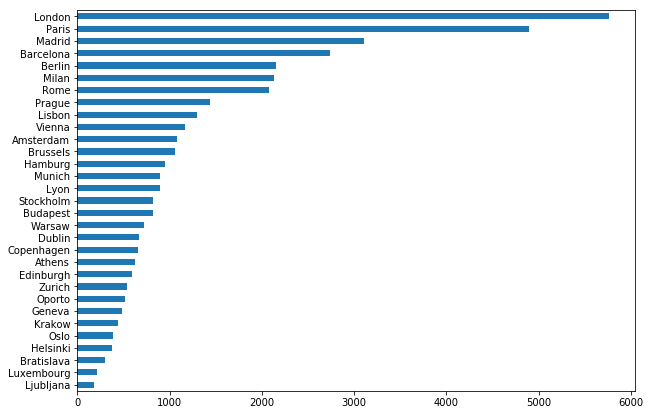

In [27]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

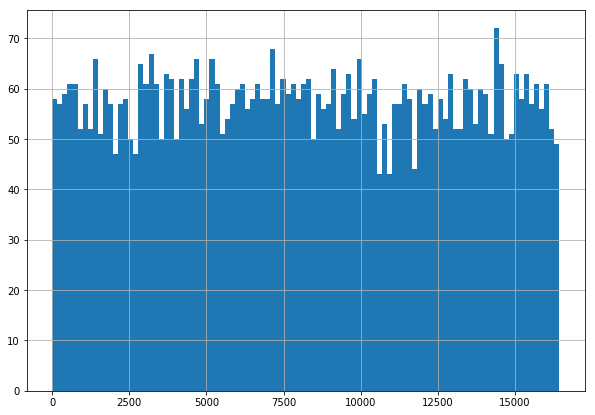

In [28]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

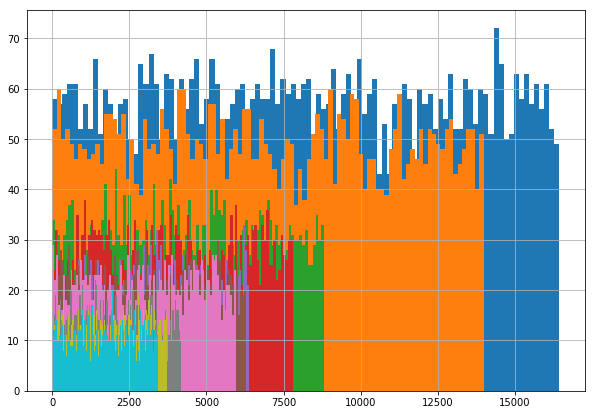

In [29]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

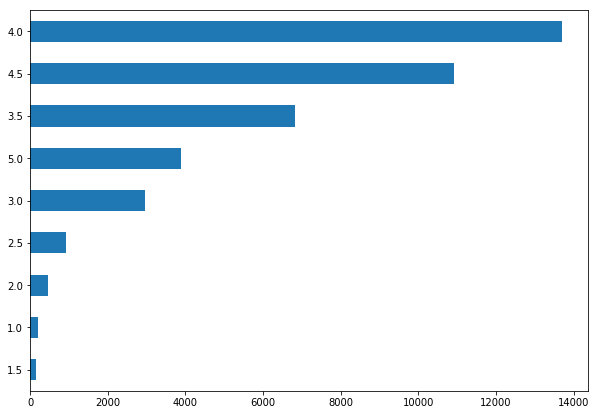

In [30]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

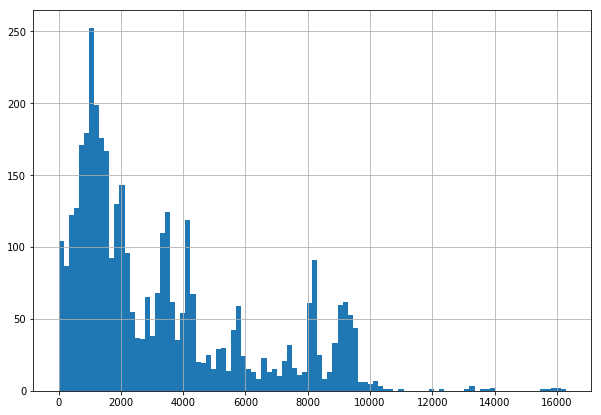

In [31]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

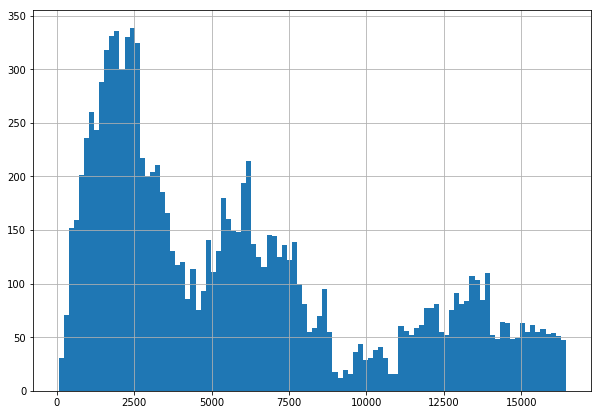

In [32]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

,Ranking,Number of Reviews,Rating,Number_of_Reviews_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,...,South American,Brew Pub,Mexican,Southwestern,African,Vietnamese,Difference date reviews (days),Count text,Count dates,ID_TA_len
Ranking,1.000000,-0.223198,-0.109897,0.094831,-0.094100,-0.094479,0.015683,-0.026436,-0.075731,-0.094241,...,-0.013807,-0.020864,-0.002665,-0.008360,0.002307,-0.009851,0.069228,-0.108039,-0.140972,0.039779
Number of Reviews,-0.223198,1.000000,0.011006,-0.106457,0.014532,-0.012802,0.009418,-0.049192,-0.022211,-0.017096,...,0.006719,0.011830,0.011874,0.008978,-0.005413,-0.015490,-0.087316,0.164492,0.214682,-0.236468
Rating,-0.109897,0.011006,1.000000,-0.000631,0.007447,0.016852,-0.000703,0.012834,-0.002550,-0.003957,...,-0.005449,-0.003139,-0.012044,-0.003837,0.005669,0.013444,-0.025971,0.001776,0.008197,0.040462
Number_of_Reviews_isNAN,0.094831,-0.106457,-0.000631,1.000000,-0.009408,0.003528,0.004132,0.031383,0.030749,-0.000049,...,0.000531,-0.012863,-0.011225,-0.005730,0.003490,-0.012392,-0.135085,-0.332510,-0.413392,0.157433
City_Amsterdam,-0.094100,0.014532,0.007447,-0.009408,1.000000,-0.021090,-0.045335,-0.040171,-0.014699,-0.027595,...,0.011874,-0.008264,0.008409,0.013087,0.005339,-0.006702,-0.022961,0.048834,0.062903,0.016266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnamese,-0.009851,-0.015490,0.013444,-0.012392,-0.006702,-0.014092,-0.025989,0.056115,0.000567,0.012018,...,-0.011166,-0.008705,-0.006983,-0.002460,-0.006987,1.000000,0.007664,0.025181,0.026401,0.004444
Difference date reviews (days),0.069228,-0.087316,-0.025971,-0.135085,-0.022961,-0.000294,-0.005523,0.025464,0.009581,0.016076,...,-0.009334,-0.009150,-0.005600,-0.004119,0.004329,0.007664,1.000000,0.259228,0.299620,-0.160645
Count text,-0.108039,0.164492,0.001776,-0.332510,0.048834,0.006738,-0.020269,-0.019313,-0.001444,0.006968,...,-0.010547,-0.002614,0.026776,0.011260,0.005150,0.025181,0.259228,1.000000,0.807503,-0.206334
Count dates,-0.140972,0.214682,0.008197,-0.413392,0.062903,0.014138,-0.025408,-0.026539,0.002286,0.005088,...,-0.007875,0.002407,0.031025,0.010293,0.004937,0.026401,0.299620,0.807503,1.000000,-0.253416


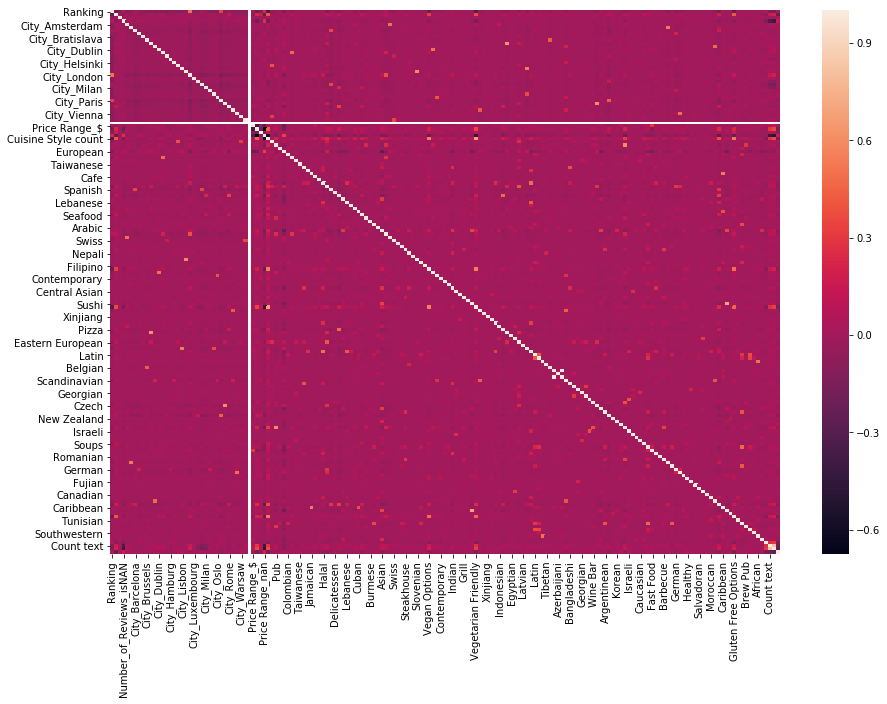

In [33]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)
display(data.drop(['sample'], axis=1).corr())

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [34]:
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [35]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
            
    df_output['Number_of_Reviews_isNAN'] = pd.isna(df_output['Number of Reviews']).astype('uint8')
    df_output['Number of Reviews'].fillna(0, inplace=True)
    
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    
    df_output = pd.get_dummies(df_output, columns=['Price Range'], dummy_na=True)
    df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna('European') 
    
    cuisines_set = set()
    def patt_cuisine_style(cuisine):
        if cuisine == 0:
            return 0
        else:
            pattern_cuisine = re.compile('[ a-zA-Z]+')
            cuisines = pattern_cuisine.findall(cuisine)
            cuisines = [item for item in cuisines if len(item) > 1]
            for cuisine in cuisines:
                cuisines_set.add(cuisine)
            return len(cuisines)
    df_output['Cuisine Style count'] = df_output['Cuisine Style'].fillna(0).apply(patt_cuisine_style) 
    def add_cuisines(cuisine_style):
        if cuisine in cuisine_style:
            return 1
        return 0

    for cuisine in cuisines_set:
        df_output[cuisine] = df_output['Cuisine Style'].apply(add_cuisines)
    
    
    def patt_reviews_text(review):
        pattern_review = re.compile('[ a-zA-Z]+')
        reviews = pattern_review.findall(str(review))
        reviews = [item for item in reviews if len(item) > 1]
        return reviews

    def patt_reviews_dates(review):
        pattern_dates = re.compile('\d\d/\d\d/\d\d\d\d')
        dates = pattern_dates.findall(str(review))
        return dates
    df_output['Review_text'] = df_output['Reviews'].apply(patt_reviews_text)
    df_output['Review_dates'] = df_output['Reviews'].apply(patt_reviews_dates)
    
    def calc_difference(rev_dates):
        if len(rev_dates) > 1:
            return np.abs((pd.to_datetime(rev_dates[0]) - pd.to_datetime(rev_dates[1])).days)
        else:
            return 0
    df_output['Difference date reviews (days)'] = np.abs(df_output['Review_dates'].apply(calc_difference))
    
    df_output['Count text'] = df_output['Review_text'].apply(lambda x: len(x))
    df_output['Count dates'] = df_output['Review_dates'].apply(lambda x: len(x))
    
    df_output['ID_TA_len'] = df_output['ID_TA'].apply(lambda x: len(x))
    
    
    df_output.drop(['Restaurant_id', 'Cuisine Style', 'Reviews', 'URL_TA', 'ID_TA',
            'Review_text', 'Review_dates'], axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [36]:
df_preproc = preproc_data(data)
df_preproc.sample(5)

,Ranking,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,South American,Brew Pub,Mexican,Southwestern,African,Vietnamese,Difference date reviews (days),Count text,Count dates,ID_TA_len
28371,871.0,10.0,1,4.5,0,0,1,0,0,0,...,0,0,0,0,0,0,191,2,2,9
11719,8351.0,2.0,1,5.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
15540,1442.0,23.0,1,4.5,0,0,0,0,0,0,...,0,0,0,0,0,0,161,2,2,8
10003,3458.0,3.0,1,5.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,8
37777,1691.0,29.0,1,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,255,2,2,8


In [37]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 172 entries, Ranking to ID_TA_len
dtypes: float64(3), int64(132), uint8(37)
memory usage: 53.3 MB


In [38]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values    # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [39]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=RANDOM_SEED)

In [40]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 171), (40000, 171), (40000, 170), (39200, 170), (800, 170))

# Model 
Сам ML

In [41]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [42]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [43]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [44]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20740625000000001


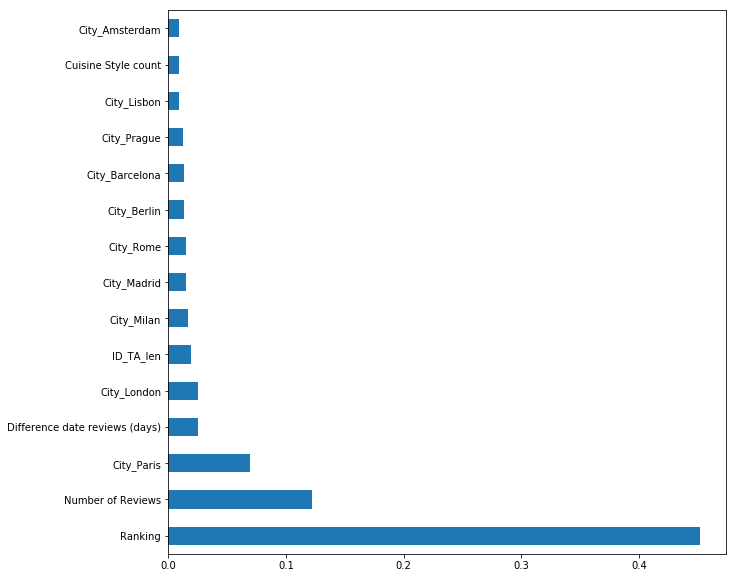

In [45]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [46]:
not_impotances = feat_importances[feat_importances<0.0001].index
list(not_impotances)

['City_nan',
 'Ecuadorean',
 'Colombian',
 'Taiwanese',
 'Balti',
 'Jamaican',
 'Mongolian',
 'Afghani',
 'Cuban',
 'Burmese',
 'Arabic',
 'Sri Lankan',
 'Chilean',
 'Welsh',
 'Slovenian',
 'Venezuelan',
 'Filipino',
 'Norwegian',
 'Native American',
 'Central Asian',
 'Polynesian',
 'Yunnan',
 'Albanian',
 'Xinjiang',
 'Hawaiian',
 'Indonesian',
 'Egyptian',
 'Malaysian',
 'Latvian',
 'Central American',
 'Ethiopian',
 'Tibetan',
 ' Creole',
 'Azerbaijani',
 'Cajun ',
 'Bangladeshi',
 'Ukrainian',
 'Minority Chinese',
 'Georgian',
 'Russian',
 'Kosher',
 'Argentinean',
 'New Zealand',
 'Israeli',
 'Uzbek',
 'Cambodian',
 'Caucasian',
 'Romanian',
 'Peruvian',
 'Fujian',
 'Croatian',
 'Salvadoran',
 'Singaporean',
 'Canadian',
 'Caribbean',
 'Australian',
 'Southwestern']

# Submission
Если все устраевает - готовим Submission на кагл

In [47]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Number_of_Reviews_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,...,South American,Brew Pub,Mexican,Southwestern,African,Vietnamese,Difference date reviews (days),Count text,Count dates,ID_TA_len
4476,2519.0,17.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,251,3,2,8
9303,4908.0,44.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,116,2,2,8
3056,5925.0,2.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1245,2427.0,3.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,8
244,11725.0,7.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,166,2,2,8
8647,1833.0,14.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,433,4,2,8
4899,378.0,53.0,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,106,2,2,8
2572,1827.0,57.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,8
9241,6331.0,32.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,8
2456,3371.0,0.0,0.0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,9


In [48]:
test_data = test_data.drop(['Rating'], axis=1)

In [49]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [50]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [51]:
predict_submission

array([3.03 , 4.36 , 4.425, ..., 3.   , 4.335, 4.125])

In [52]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.030
1,id_1,4.360
2,id_2,4.425
3,id_3,4.385
4,id_4,4.500
5,id_5,4.430
6,id_6,1.605
7,id_7,2.610
8,id_8,4.150
9,id_9,4.505


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
